In [11]:
import dataframe_image as dfi
import xgboost
import os
import shap

from fpdf import FPDF
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.inspection import PartialDependenceDisplay as PDP
from sklearn.inspection import partial_dependence as pdep
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


%load_ext autoreload
%autoreload 2
import market_models.src.features.build_features as build_features

xgboost.set_config(verbosity=0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def prepareDir(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    for file in os.listdir(dir):
        os.remove(dir + file)

In [51]:
####### PATHS

INPUT = '../data/processed/'
INTERMEDIATE = '../reports/'
OUTPUT = '..data/processed/'

DATA_NAME = 'netrisk_casco_2023_11_14__2023_11_20'

DATA_PATH = f'{INPUT}{DATA_NAME}_processed.csv'
FEATURES_PATH = f'{INPUT}{DATA_NAME}_features.txt'
CATEGORIES_PATH = f'{INPUT}external/'


####### CONSTANTS

TEST_SIZE = 0.1
RANDOM_STATE = 42


def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain.get_labels()
    c = 1
    den = abs(x) + c
    grad = c * x / den
    hess = c * c / den ** 2
    return grad, hess


DEFAULT_PARAMS = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'eval_metric': 'mae',
    'n_estimators': 100,
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'num_boost_round': 100,
    'early_stopping_rounds': None,
    'seed': 42
}



BONUS_MALUS_CLASSES = ['B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2', 'B1', 'A0', 'M1', 'M2', 'M3', 'M4']
KPI_TABLE_COLUMNS = ['MAE', 'RMSE', 'MAPE', 'Avg target']

TARGET_VARIABLE = 'ALFA_price'
PRED_TARGET_VARIABLE = f'predicted_{TARGET_VARIABLE}'
CATEGORIES_PATH = f'{CATEGORIES_PATH}{TARGET_VARIABLE}'

KPI_DATA_PATH = f'{INTERMEDIATE}{DATA_NAME}_{TARGET_VARIABLE}_pdf_data/'
PDF_PATH = KPI_DATA_PATH

prepareDir(KPI_DATA_PATH)

In [52]:
KPI_DATA_PATH

'../reports/netrisk_casco_2023_11_14__2023_11_20_ALFA_price_pdf_data/'

In [53]:
DATA = pd.read_csv(DATA_PATH)

In [54]:
DATA.filter(like = '_price').mean(axis = 0).round()

ALFA_price        135802.0
ALLIANZ_price     161056.0
GENERALI_price    150579.0
GENERTEL_price         NaN
GROUPAMA_price    132804.0
K&AMP;H_price     197895.0
KÖBE_price         93531.0
MAGYAR_price      118104.0
SIGNAL_price      172852.0
UNION_price       129383.0
UNIQA_price       138465.0
WÁBERER_price     136950.0
dtype: float64

In [55]:
DATA = pd.read_csv(DATA_PATH)
with open(FEATURES_PATH) as file:
    FEATURES = file.readlines()
    FEATURES = [feature.replace('\n', '') for feature in FEATURES]
    feature_dtypes = {feature.split(',')[0]: feature.split(',')[1] for feature in FEATURES}
    FEATURES = [feature.split(',')[0] for feature in FEATURES]

for feature in FEATURES:
    DATA[feature] = DATA[feature].astype(feature_dtypes[feature])
    if DATA[feature].dtype == 'category' and feature == 'BonusMalus':
        ordinal_encoder = OrdinalEncoder(categories=[BONUS_MALUS_CLASSES])
        DATA[feature] = ordinal_encoder.fit_transform(DATA[[feature]])
    elif DATA[feature].dtype == 'category':
        label_encoder = LabelEncoder()
        DATA[feature] = label_encoder.fit_transform(DATA[feature])

In [56]:
# Make last column name a variable to generelize
DATA = DATA[FEATURES + [TARGET_VARIABLE]]
DATA = DATA.dropna()
TRAIN_DATA, TEST_DATA = train_test_split(DATA, test_size=0.2, random_state=42)


In [57]:
# Make data overview

describe = pd.concat([DATA.describe(),
                      pd.DataFrame(np.array([len(DATA[col].unique()) for col in DATA.columns]).reshape(1, -1),
                                   index=['unique'], columns=DATA.columns)])
describeStyle = describe.T.style.format(precision=2)
dfi.export(describeStyle, KPI_DATA_PATH + 'dataOverview.png', dpi=200)

In [58]:
# Various model related methods

def makeDMatrix(data_features: pd.DataFrame,
                data_target: pd.DataFrame) -> xgboost.DMatrix:
    return xgboost.DMatrix(data_features, data_target, enable_categorical=True)

def model_train(train_data: pd.DataFrame = None, 
                test_data: pd.DataFrame = None, 
                features : list = FEATURES,
                target_variable: str = TARGET_VARIABLE, 
                param: dict = None) -> xgboost.Booster:
    
    if train_data is None:
        train_data = TRAIN_DATA
    
    if test_data is None:
        test_data = TEST_DATA
        
    if param is None:
        param = DEFAULT_PARAMS.copy()
    
    dtrain = xgboost.DMatrix(train_data[features], train_data[target_variable], enable_categorical=True)
    dtest = xgboost.DMatrix(test_data[features], test_data[target_variable], enable_categorical=True)

    param['max_depth'] = int(param['max_depth'])
    param['eval_metric'] = 'mae'

    eval_list = [(dtrain, 'train'), (dtest, 'eval')]

    return xgboost.train(param, dtrain, num_boost_round=param['n_estimators'], evals=eval_list, verbose_eval=False)


def merge_predictions(model: xgboost.Booster,
                     test_data: pd.DataFrame = None,
                     features: list = FEATURES,
                     target_variable: str = TARGET_VARIABLE) -> pd.DataFrame:
    
    if test_data is None:
        test_data = TEST_DATA
        
    pred_target_variable = f'predicted_{target_variable}'
    output = test_data.copy()
    
    dtest = makeDMatrix(test_data[features], test_data[target_variable])
    output[pred_target_variable] = model.predict(dtest)
 
    output['error'] = output[target_variable] - output[pred_target_variable]
    output['percentageError'] = output['error'] / output[target_variable] * 100
    return output


def plotHistErrorPercenage(prediction_data : pd.DataFrame) -> None:
    plt.hist(prediction_data.percentageError, range=[-100, 100], bins=40,
             weights=np.ones(len(prediction_data.percentageError)) / len(prediction_data.percentageError))
    plt.xlabel('Error percentage')
    plt.ylabel('Percent of errors')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.savefig(KPI_DATA_PATH + 'ErrorDistribution.jpg')
    plt.show()


def plotFeatureDistribution(data: pd.DataFrame = None, feature : str = FEATURES[0]) -> None:
    
    if data is None:
        data = DATA
    
    plt.figure(figsize=(10, 10))
    if feature in feature_dtypes.keys() and feature_dtypes[feature] == 'bool':
        data[feature].value_counts().plot(kind='bar', title=feature)
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches='tight')
    else:
        plt.hist(data[feature], bins=40, weights=np.ones(len(data[feature])) / len(data[feature]), alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Percent of values')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches='tight')
    plt.close()



In [59]:
from typing import Optional


def kFoldCrossValidation(k: int = 5, 
                         data: pd.DataFrame = None,
                         features: list = FEATURES,
                         target_variable: str = TARGET_VARIABLE, 
                         param: Optional[dict] = DEFAULT_PARAMS, 
                         debug: bool = True) -> tuple:
    
    if data is None:
        data = DATA

    maes = []
    mses = []
    mapes = []
    
    kf = KFold(n_splits=k)
    fold_num = 0
    for train_ix, test_ix in kf.split(data):
        
        fold_num += 1
        
        train_data, test_data = data.iloc[train_ix], data.iloc[test_ix]
        model = model_train(train_data, test_data, features, target_variable, param)
        
        dtest = makeDMatrix(test_data[features], test_data[target_variable])
        test_preds = model.predict(dtest)
        
        mae = mean_absolute_error(test_data[target_variable].values, test_preds)
        mse = mean_squared_error(test_data[target_variable].values, test_preds)
        mape = mean_absolute_percentage_error(test_data[target_variable].values, test_preds)
        
        if debug:
            print(f"Summary for fold {fold_num}")
            print("Mean absolute error is {}, which is {}% of mean {}.".format(round(mae, 3), round(
                mae / data[target_variable].mean() * 100, 3), target_variable))
            print("Mean square error is {}.".format(round(mse, 3)))
            print("Mean absolute percentage error is {}%.".format(round(mape * 100, 3)))
            print("-------------------------------------------------------------")
        
        maes.append(mae)
        mses.append(mse)
        mapes.append(mape)

    mMae, sMae = np.mean(maes), np.std(maes)
    mRMse, sRMse = np.mean(np.sqrt(mses)), np.std(np.sqrt(mses))
    mMape, sMape = np.mean(mapes), np.std(mapes)
    meanPrice = data[target_variable].mean()

    rmMae, rsMae = round(mMae, 2), round(sMae / mMae * 100, 3)
    rmRMse, rsRMse = round(mRMse, 2), round(sRMse / mRMse * 100, 2)
    rmMape, rsMape = round(mMape * 100, 2), round(sMape / mMape, 3)

    if debug:
        print(
            f"Mean MAE over {k} fold Cross-validation is {rmMae} ± {rsMae}%, which is {round(mMae / meanPrice * 100, 3)} ± {round(sMae / meanPrice * 100, 3)}% percent of mean {target_variable}.")
        print(f"Mean RMSE over {k} fold Cross-validation is {rmRMse} ± {rsRMse}%.")
        print(f"Mean MAPE over {k} fold Cross-validation is {rmMape} ± {rsMape}%.")

    return rmMae, rmRMse, rmMape

In [60]:
hyperparameter_ranges = {
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(100, 1100, 100),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': np.arange(0.5, 1.01, 0.1),
    'colsample_bytree': np.arange(0.5, 1.01, 0.1),
    'gamma': np.arange(0, 0.21, 0.01),
    'lambda': np.arange(0, 1.1, 0.1),
}


def hyperparameter_tuning(data: pd.DataFrame = None,
                          features: list = FEATURES,
                          target_variable: str = TARGET_VARIABLE,
                          params: dict = None, 
                          plot_search=False) -> tuple:
    
    if data is None:
        data = DATA
    
    if params is None:
        params = DEFAULT_PARAMS.copy()
    
    best_hyperparameters = {}  # To store the best hyperparameter value for each parameter
    min_mae_values = {}  # To store the corresponding minimum MAE values

    for hp, hp_values in hyperparameter_ranges.items():
        maes = []
        print(f"Iterating over {hp} values...")

        # Initialize the minimum MAE and corresponding hyperparameter value
        min_mae = float('inf')
        best_value = None
        current_params = params
        for value in hp_values:
            current_params[hp] = value
            mae, mse, mape = kFoldCrossValidation(3, data, features, target_variable, params, debug = False)
            maes.append(mae)

            # Check if the current value gives a lower MAE
            if mae < min_mae:
                min_mae = mae
                best_value = value

        # Store the best hyperparameter value in the dictionary
        best_hyperparameters[hp] = best_value
        min_mae_values[hp] = min_mae

        if plot_search:
            # Plot the results
            plt.title(f'Search for optimal {hp} value:')
            plt.plot(hp_values, maes)
            plt.xlabel(f'{hp}')
            plt.ylabel('Mean Absolute Error (MAE)')
            plt.show()

    # Display the best hyperparameter values
    print("\nBest Hyperparameter Values:")
    for hp, value in best_hyperparameters.items():
        print(f"{hp}: {value}")

    mae, mse, mape = kFoldCrossValidation(3, data, features, target_variable, best_hyperparameters, debug = False)

    return best_hyperparameters, mae

In [63]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1300, 100, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 0.2),
    'lambda': hp.uniform('lambda', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 40, 180),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'seed': 0,
}


def objective(space):
    params = space.copy()
    mae, rmse, mape = kFoldCrossValidation(k = 3, param = params, debug = False)
    print(f"Score: {mae}")
    return {"loss": mae, 'status': STATUS_OK}


trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials,
                        return_argmin=False)

Score: 12441.28                                        
Score: 12349.57                                                        
Score: 10714.66                                                        
Score: 12611.28                                                        
Score: 12487.29                                                        
Score: 12645.95                                                        
Score: 12542.69                                                        
Score: 13736.27                                                        
Score: 13719.01                                                        
Score: 14702.06                                                        
Score: 11197.1                                                          
Score: 10789.42                                                         
Score: 12191.14                                                         
Score: 12543.19                                                         
Scor

In [18]:
best_hyperparams

{'colsample_bytree': 0.7990952298930174,
 'gamma': 0.1597626612420071,
 'lambda': 0.7372184288773219,
 'learning_rate': 0.05104778761410624,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 1100,
 'reg_alpha': 145.11167707974502,
 'reg_lambda': 0.21313506029488205,
 'seed': 0,
 'subsample': 0.807024535806713}

In [64]:
mae, rmse, mape = kFoldCrossValidation(k=3, param=best_hyperparams, debug=True)

Summary for fold 1
Mean absolute error is 12417.296, which is 9.226% of mean ALFA_price.
Mean square error is 761715029.246.
Mean absolute percentage error is 6.429%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 7978.487, which is 5.928% of mean ALFA_price.
Mean square error is 213832974.109.
Mean absolute percentage error is 5.977%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 8763.737, which is 6.511% of mean ALFA_price.
Mean square error is 328513894.777.
Mean absolute percentage error is 6.225%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 9719.84 ± 19.899%, which is 7.221 ± 1.437% percent of mean ALFA_price.
Mean RMSE over 3 fold Cross-validation is 20115.72 ± 27.25%.
Mean MAPE over 3 fold Cross-validation is 6.21 ± 0.03%.


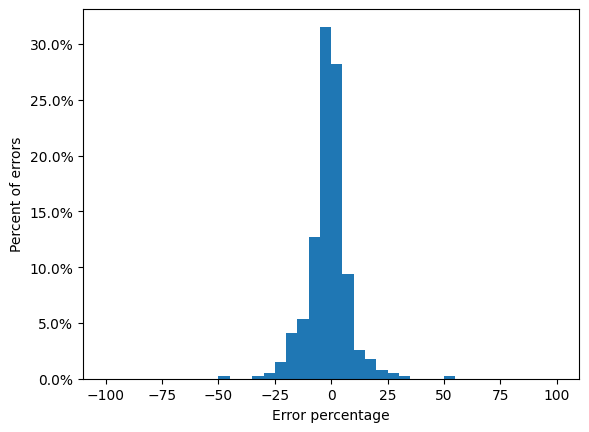

0.10     0.381001
0.20     1.087348
0.30     1.971559
0.40     2.864937
0.50     3.718707
0.60     5.022206
0.70     6.576777
0.80     9.628457
0.90    15.011002
0.99    29.933312
Name: percentageError, dtype: float64

In [65]:
model = model_train()
out = merge_predictions(model)
plotHistErrorPercenage(out)
out.percentageError.abs().quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])

In [66]:
kFoldCrossValidation(k = 3, data = out, features = FEATURES, target_variable = 'error')

Summary for fold 1
Mean absolute error is 10839.638, which is 1199.226% of mean error.
Mean square error is 681657093.452.
Mean absolute percentage error is 758.392%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 9971.649, which is 1103.198% of mean error.
Mean square error is 866413673.995.
Mean absolute percentage error is 686.68%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 14664.992, which is 1622.438% of mean error.
Mean square error is 1691588995.638.
Mean absolute percentage error is 325.681%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 11825.43 ± 17.242%, which is 1308.288 ± 225.571% percent of mean error.
Mean RMSE over 3 fold Cross-validation is 32224.13 ± 19.99%.
Mean MAPE over 3 fold Cross-validation is 590.25 ± 0.321%.


(11825.43, 32224.13, 590.25)

In [408]:
kpi_data = [[mae, rmse, mape, round(data[TARGET_VARIABLE].mean(), 1)]]
kpi = pd.DataFrame(data=kpi_data, columns=KPI_TABLE_COLUMNS).astype('str')

In [23]:
for col in DATA.columns:
    plotFeatureDistribution(feature = col)

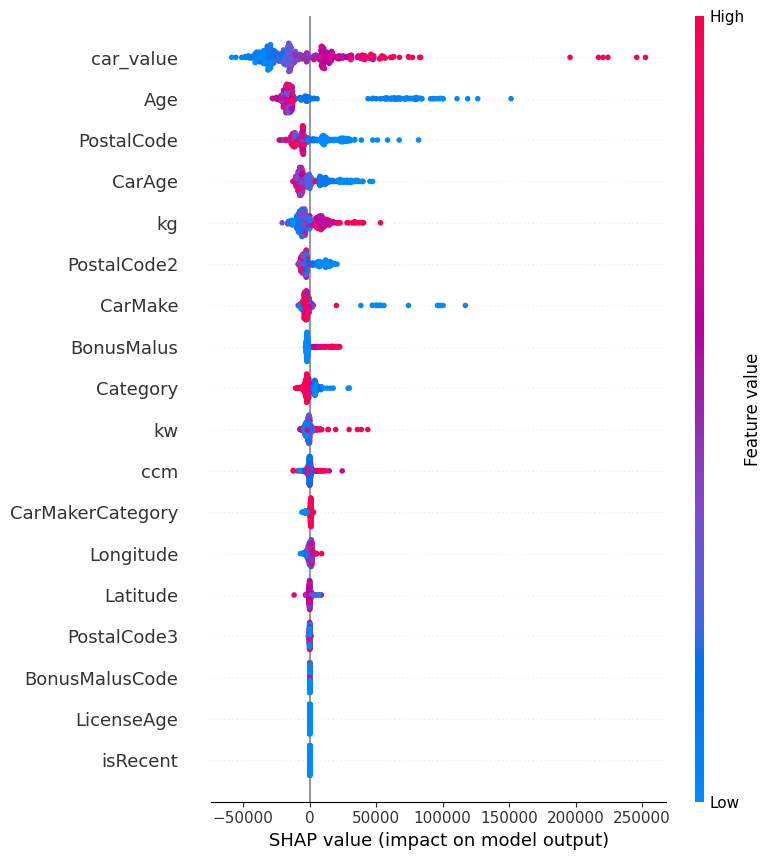

In [67]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(TEST_DATA[FEATURES].values)

shap.summary_plot(shap_values, TEST_DATA[FEATURES], feature_names=FEATURES)

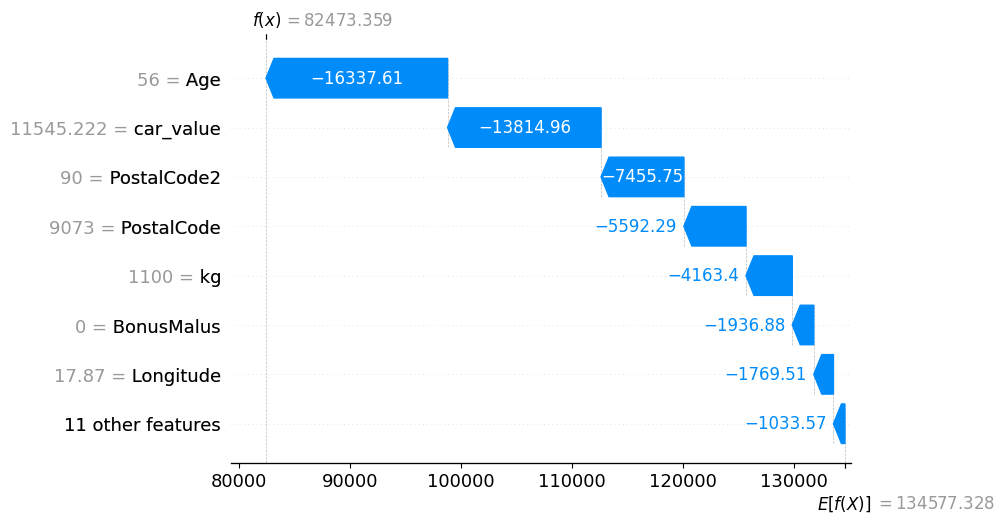

In [68]:
id = 21
plt.figure(figsize=(20, 20))
shap.waterfall_plot(shap.Explanation(values=shap_values[id],
                                     base_values=explainer.expected_value,
                                     data=TEST_DATA.iloc[id],
                                     feature_names=FEATURES),
                    max_display=8)  # Adjust max_display as needed

plt.show()

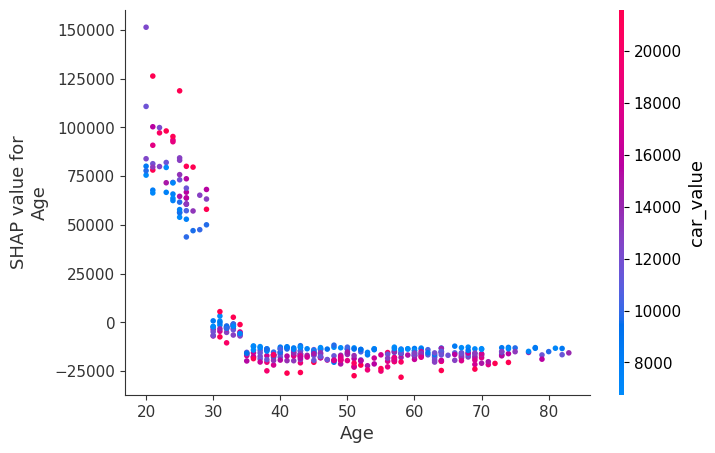

In [71]:
shap.dependence_plot('Age', shap_values, TEST_DATA[FEATURES])

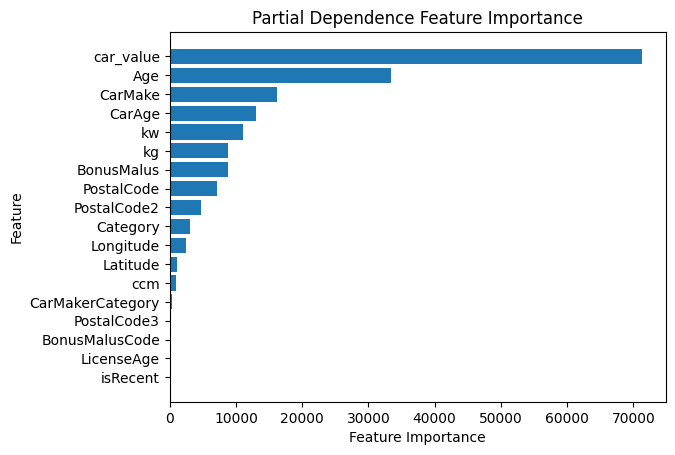

In [72]:
def partial_dependence_analysis(model: xgboost.Booster,
                                data: pd.DataFrame = None,
                                feature_names: list = FEATURES,
                                grid_resolution : int = 100) -> tuple:
    
    if data is None:
        data = TRAIN_DATA
    
    importance_dict = {}
    pdp_dict = {}

    for feature_name in feature_names:
        if data[feature_name].dtype == 'category':  # Check if the variable is categorical
            unique_values = data[feature_name].unique()
            partial_dependence_values = []

            for value in unique_values:
                data_copy = data.copy()
                data_copy[feature_name] = value
                dmatrix = xgboost.DMatrix(data_copy.drop(TARGET_VARIABLE, axis=1))
                predictions = model.predict(dmatrix)
                partial_dependence_values.append(np.mean(predictions))

            importance_dict[feature_name] = np.std(partial_dependence_values)
            pdp_dict[feature_name] = (unique_values, partial_dependence_values)
        else:
            feature_range = np.linspace(data[feature_name].min(), data[feature_name].max(), grid_resolution)
            partial_dependence_values = []

            for value in feature_range:
                data_copy = data.copy()
                data_copy[feature_name] = value
                dmatrix = xgboost.DMatrix(data_copy.drop(TARGET_VARIABLE, axis=1))
                predictions = model.predict(dmatrix)
                partial_dependence_values.append(np.mean(predictions))

            importance_dict[feature_name] = np.std(partial_dependence_values)
            pdp_dict[feature_name] = (feature_range, partial_dependence_values)

    return pdp_dict, importance_dict

grid_resolution = 100
pdp_dict, feature_importance_dict = partial_dependence_analysis(model, DATA, FEATURES, grid_resolution)

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)
features_, importance_values = zip(*sorted_feature_importance)

plt.barh(features_, importance_values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Partial Dependence Feature Importance')
plt.savefig(KPI_DATA_PATH + 'PDPimportancePlot.jpg', bbox_inches='tight')



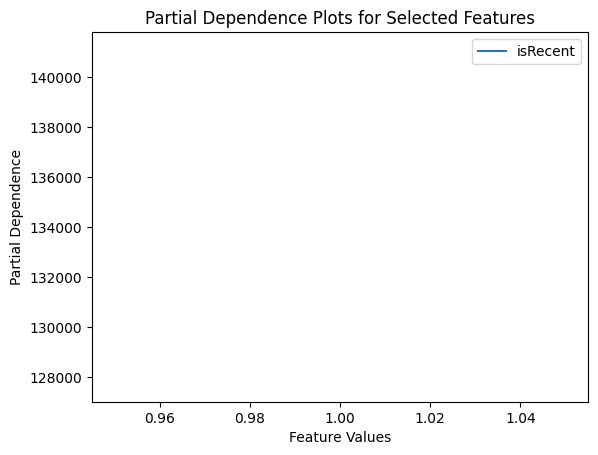

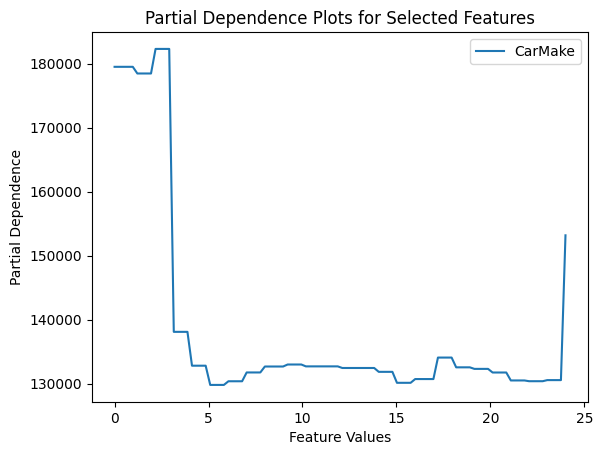

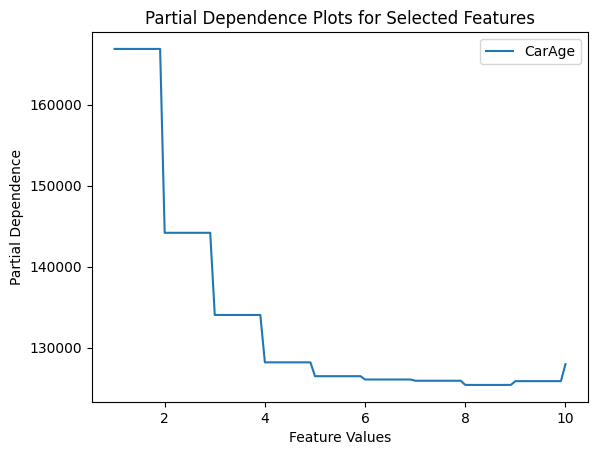

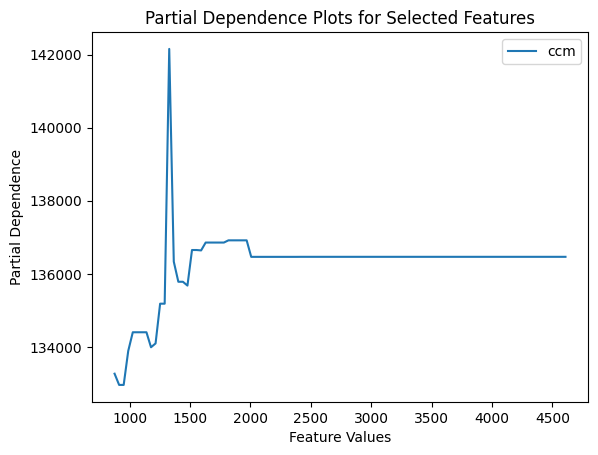

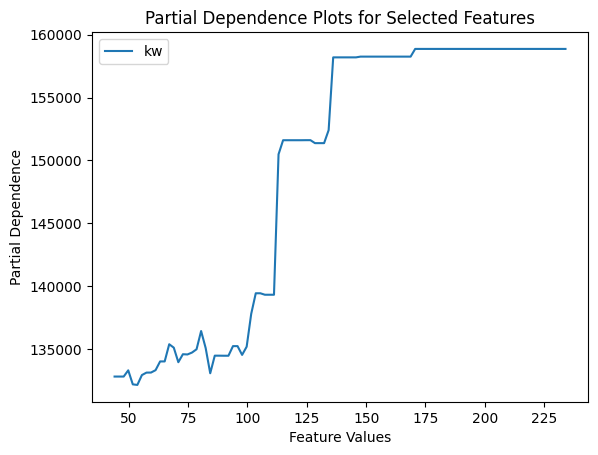

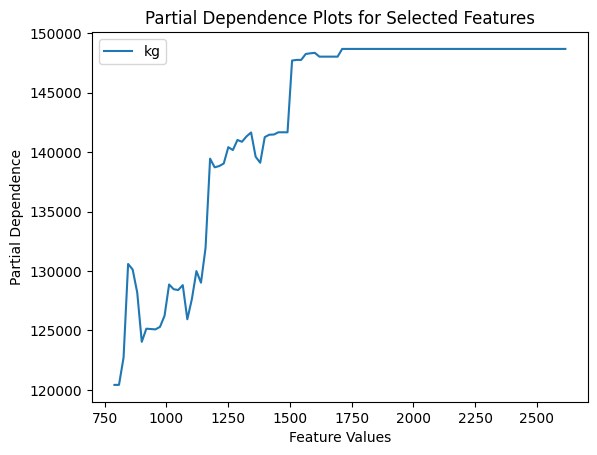

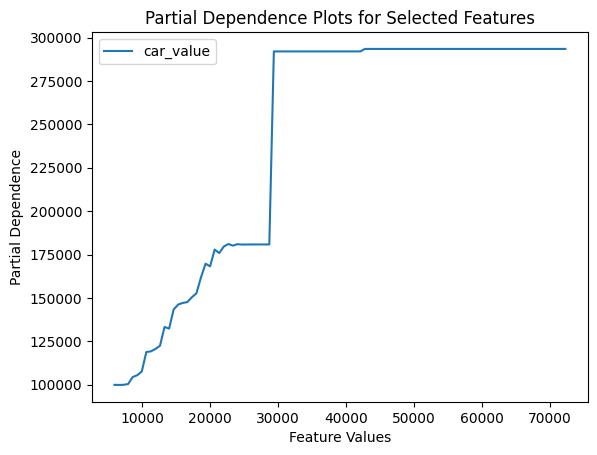

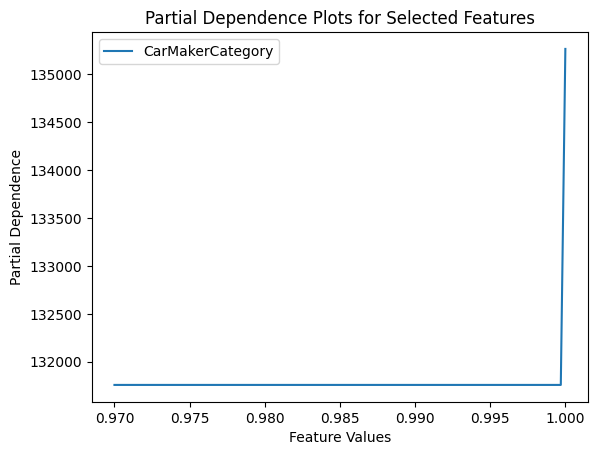

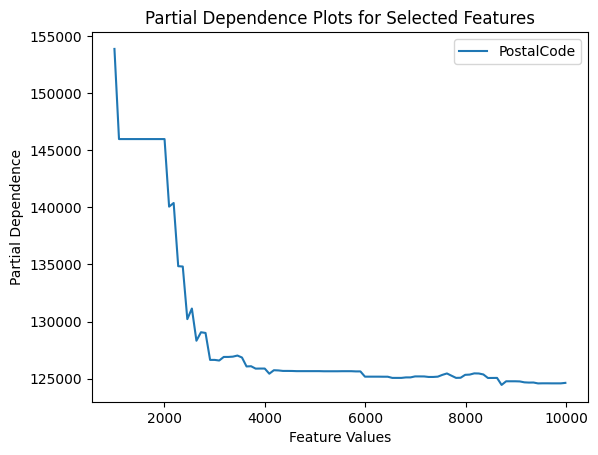

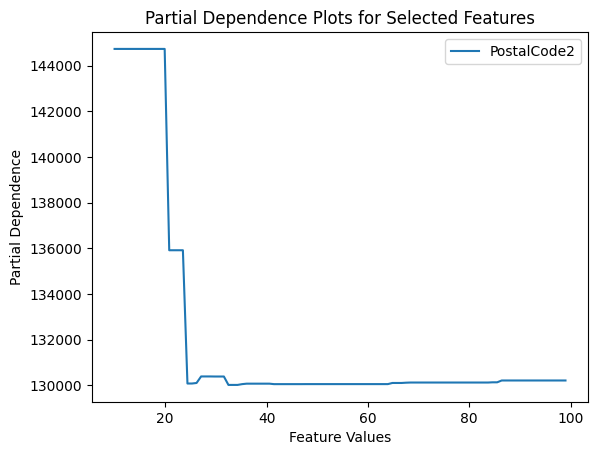

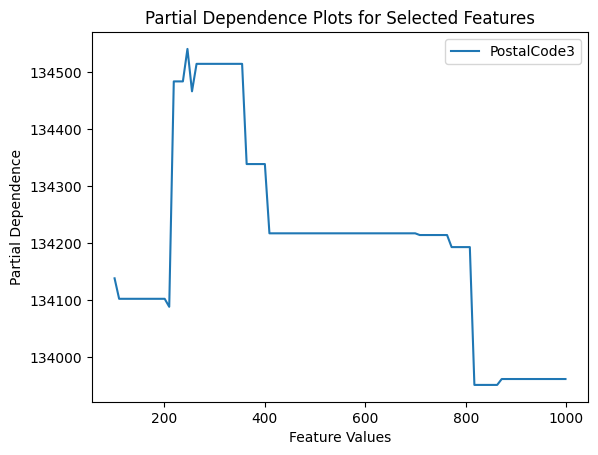

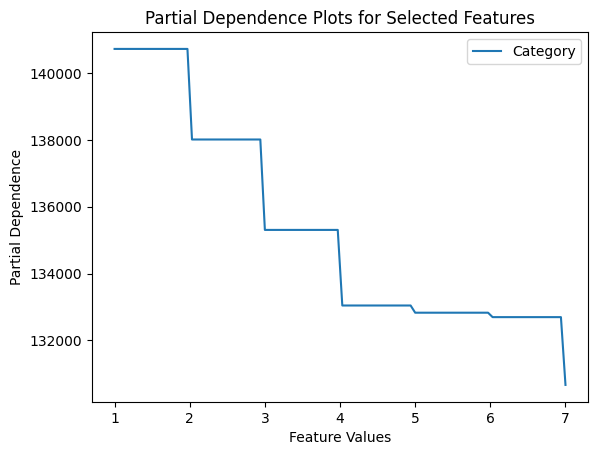

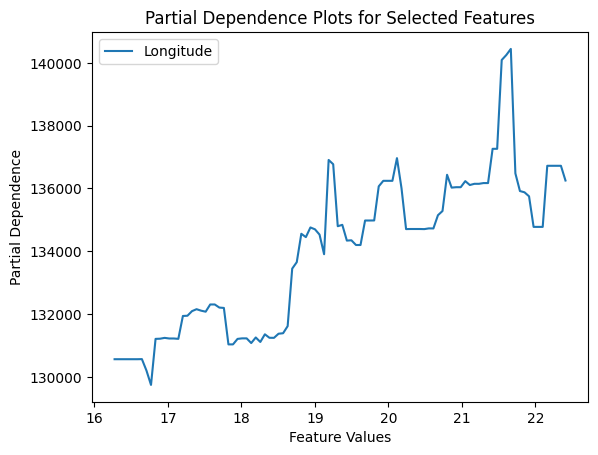

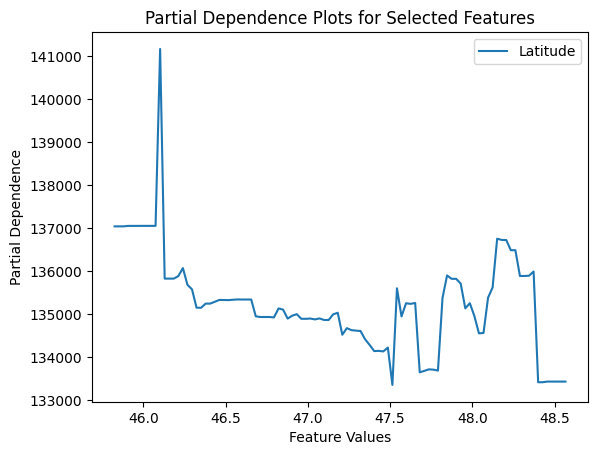

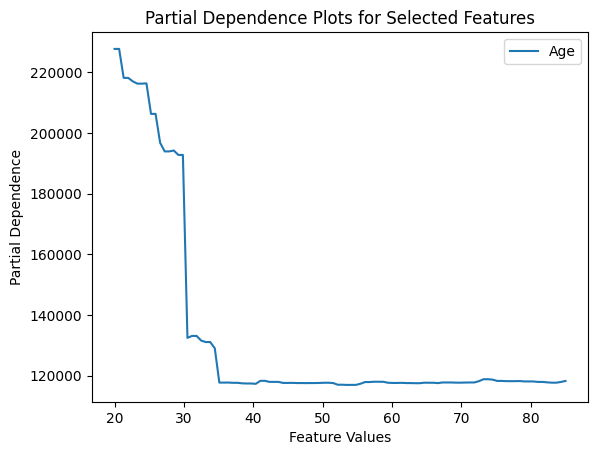

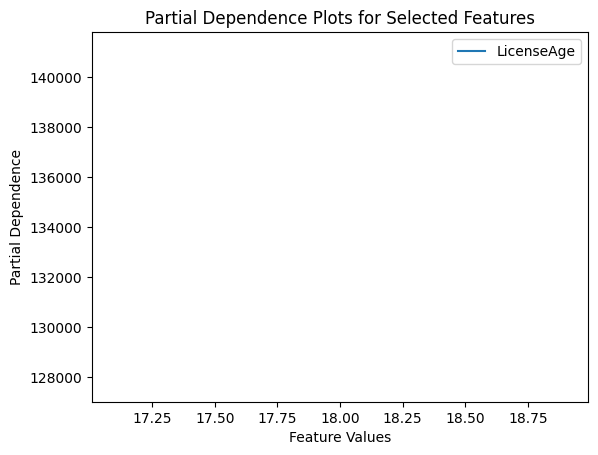

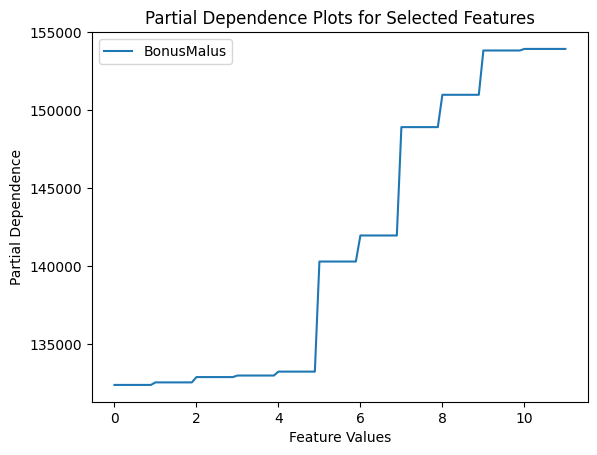

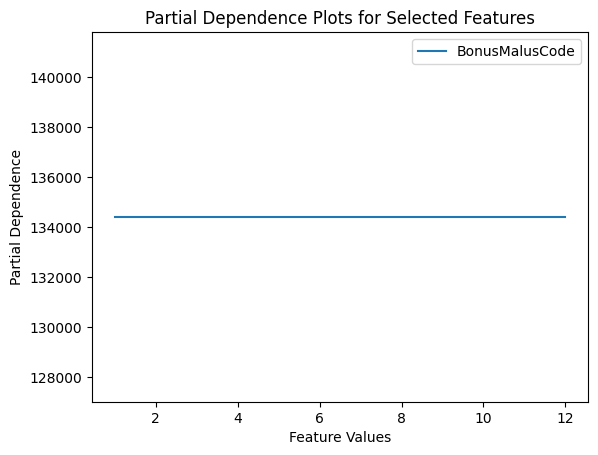

In [73]:
for feature in FEATURES:
    feature_range, pdp_values = pdp_dict[feature]
    plt.plot(feature_range,pdp_values, label=feature)
    plt.xlabel('Feature Values')
    plt.ylabel('Partial Dependence')
    plt.title('Partial Dependence Plots for Selected Features')
    plt.legend()
    plt.show()

In [415]:
pdp_dict['car_value'][1]

[95617.66,
 95617.66,
 96060.63,
 98887.93,
 98887.93,
 100154.45,
 100380.58,
 100380.58,
 102875.03,
 106694.586,
 106694.586,
 108257.12,
 108166.234,
 108186.27,
 108640.92,
 108230.98,
 114429.84,
 135943.55,
 122935.28,
 122982.69,
 126497.61,
 129956.32,
 131284.81,
 128154.27,
 128470.7,
 128811.836,
 128783.15,
 130551.46,
 130627.28,
 138302.28,
 138515.45,
 139442.17,
 138954.05,
 138947.9,
 147915.86,
 146078.5,
 146078.5,
 156311.75,
 156281.16,
 156113.84,
 156114.34,
 156114.34,
 156147.97,
 156795.95,
 156857.89,
 159630.86,
 159630.86,
 159630.86,
 162529.31,
 172943.16,
 185025.48,
 184554.72,
 186250.1,
 192877.48,
 203838.06,
 203838.06,
 205232.78,
 213029.8,
 213029.8,
 212587.58,
 212444.9,
 212370.19,
 212370.19,
 212370.19,
 212814.47,
 211644.11,
 201901.05,
 201901.05,
 201901.05,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 195643.19,
 

In [416]:
def getQauntSplit(step=50):
    return [i / 1000 for i in range(0, 1001, step)]


quant = getQauntSplit(int(np.ceil(100000 / len(TRAIN_DATA))))
qr = TEST_DATA[TARGET_VARIABLE].quantile(quant)
qp = pd.Series(model.predict(makeDMatrix(TEST_DATA[FEATURES], TEST_DATA[TARGET_VARIABLE]))).quantile(quant)

plt.scatter(qr, qp, alpha=0.8, s=40)
x = np.linspace(qr.min(), qr.max())
plt.plot(x, x, c='r')
plt.xlabel('Real quantiles for training data')
plt.ylabel('Predicted quantiles for training data')
plt.savefig(KPI_DATA_PATH + 'QQplot.jpg', bbox_inches='tight')
plt.close()

In [417]:
TEST_DATA[FEATURES]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode
1970,True,18,4,898,56,1090,9097.40,1.00,9800,98,980,7,16.7995,47.0493,40,18,0.0,1
1402,True,22,9,998,51,1005,8749.00,0.97,5732,57,573,7,21.5333,46.8667,54,18,0.0,1
863,True,16,3,1199,81,1441,17238.00,1.00,1048,10,104,1,19.0404,47.4984,38,18,0.0,1
572,True,10,2,998,49,899,15337.40,1.00,4145,41,414,7,21.3000,47.0333,25,18,7.0,8
672,True,21,9,996,50,855,6497.40,1.00,2464,24,246,4,18.7340,47.3719,57,18,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,True,16,2,1199,55,1055,17420.00,1.00,2536,25,253,5,18.5569,47.7603,36,18,0.0,1
795,True,18,3,999,74,1190,15597.40,1.00,1027,10,102,2,19.0404,47.4984,51,18,0.0,1
1090,True,5,5,1198,85,1205,10244.00,0.97,6725,67,672,7,20.1482,46.2530,50,18,0.0,1
372,True,20,4,999,44,1086,12697.62,1.00,2146,21,214,2,19.2407,47.5975,33,18,0.0,1


In [418]:
def quantPlot(out, feature, numQuant=20):
    type = True  # Does the feature have more than 20 unique values in train data, 20 because it looks bad with more
    fQuant = None
    cats = None
    if len(out[feature].unique()) > 30 and feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object':
        return
    if len(out[feature].unique()) < numQuant or (
            feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object'):
        out['QuantCat'] = out[feature]
        type = False
    else:
        fQuant = out[feature].quantile(getQauntSplit(1000 // numQuant)).values
        cats = list(pd.Series(fQuant).unique())

        def getQId(x):
            for i in range(0, len(cats) - 1):
                if x >= cats[i] and x <= cats[i + 1]:
                    return i
            return len(cats) - 1

        out['QuantCat'] = out[feature].apply(lambda x: getQId(x))
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]

    agg_age = out.groupby('QuantCat')

    fig, ax = plt.subplots(figsize=(14, 14))
    if type:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        ax.set_xticks(sorted(list(out['QuantCat'].unique())))
    else:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        if feature == 'CarMaker':
            ax.set_xticklabels(sorted([str(x)[:4] for x in list(out['QuantCat'].unique())]))
        else:
            ax.set_xticklabels(sorted(list(out['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real', 'Predicted'])
    plt.savefig(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', bbox_inches='tight')
    plt.close()
    ret = pd.DataFrame(agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean())
    #print(ret)
    if type:
        #print(cats, out['QuantCat'].unique())
        ret.index = [cats[i] for i in range(len(cats)) if i in out['QuantCat'].unique()]

    return ret


out = mergePredictions(model)
agg_errors = {}
for col in TEST_DATA.columns:
    agg_errors[col] = quantPlot(out, col)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [419]:
# Function to compare two models based on quantile mean aggregated by a feature

def quantPlots(outs, feature, numQuant=20):
    type = True
    fQuant = None
    featureCol = outs[0][feature]
    if len(featureCol.unique()) < numQuant:
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = featureCol
        type = False
    else:
        fQuant = featureCol.quantile(getQauntSplit(1000 // numQuant)).values
        print(fQuant)

        def getQId(x):
            id = 0
            while id < len(fQuant) - 1 and x > fQuant[id]:
                id += 1
                if x <= fQuant[id]:
                    break
            return max(0, id - 1)

        quantCat = featureCol.apply(lambda x: getQId(x))
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = quantCat

    agg_ages = [outs[i].groupby('QuantCat') for i in range(0, len(outs))]
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_ages[0][TARGET_VARIABLE].mean(), marker='o', color='b',
            alpha=0.6)
    for agg_age in agg_ages:
        ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean(), marker='o', color='r',
                alpha=0.6)
    if type:
        ax.set_xticks(range(0, numQuant + 1))
    else:
        ax.set_xticks(sorted(list(outs[0]['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real'] + ['Predicted' + str(i) for i in range(1, len(outs) + 1)])
    plt.savefig(KPI_DATA_PATH + 'quantPlots' + col + '.jpg', bbox_inches='tight')
    plt.show()
    ret = pd.DataFrame(
        np.array([agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean() for agg_age in agg_ages])).T
    ret.columns = ['Model' + str(i) + ' error' for i in range(1, len(outs) + 1)]
    print(ret.index)
    if type:
        cats = list(pd.Series(fQuant).unique())
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]
        for i in range(len(cats)):
            print(feature, cats[i], agg_age[TARGET_VARIABLE].mean().iloc[i])
        ret.index = cats

    return ret

In [420]:
# Inherits FPDF class

class PDF(FPDF):
    def __init__(self):
        super().__init__()

    def header(self):
        self.set_font('Arial', '', 12)
        self.cell(0, 8, 'Model', 0, 1, 'C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 12)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')


# Create the KPI report PDF

def makePDF():
    ch = 8
    QUANT_W = 120
    QUANT_H = 120

    pdf = PDF()
    pdf.add_page()
    pdf.set_font('Arial', '', 12)

    for j in range(len(kpi.columns)):
        pdf.cell(w=25, h=ch, txt=kpi.columns[j], border=1, ln=j == (len(kpi.columns) - 1), align='C')
    for j in range(len(kpi.columns)):
        pdf.cell(w=25, h=ch, txt=kpi[kpi.columns[j]].iloc[0] + ('%' if j % 2 else ''), border=1, ln=0, align='C')

    pdf.set_font('Arial', '', 12)
    pdf.cell(w=40, h=3 * ch, txt=' ', border=0, ln=1, align='C')
    pdf.cell(w=40, h=ch, txt='Parameter', border=1, ln=0, align='C')
    pdf.cell(w=40, h=ch, txt='Value', border=1, ln=0, align='C')
    pdf.cell(w=75, h=ch, txt='GridSpace', border=1, ln=1, align='C')
    #    for col, val in params.items():
    #        pdf.cell(w = 40, h = ch, txt = col, border = 1, ln = 0, align = 'C')
    #        pdf.cell(w = 40, h = ch, txt = str(val), border = 1, ln = 0, align = 'C')
    #        pdf.cell(w = 75, h = ch, txt = str(paramsGrid[col]), border = 1,  ln = 1, align = 'C')

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'dataOverview.png', w=200, h=120, type='PNG')

    pdf.add_page()

    idx = 1
    for col in FEATURES:
        pdf.image(KPI_DATA_PATH + col + 'Distribution.jpg', x=10, y=5 + (idx - 1) * 90, w=150, h=90, type='JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'PDPimportancePlot.jpg', w=160, h=200, type='JPG')
    pdf.image(KPI_DATA_PATH + 'QQplot.jpg', w=150, h=150, x=100, type='JPG')
    #pdf.image('quantPlotminPrice.jpg', w = 150, h = 150, x = 100, type = 'JPG')

    pdf.add_page()
  #  idx = 1
  #  for col in transposed_train[FEATURES].select_dtypes(include='number').columns:
  #      pdf.image(KPI_DATA_PATH + 'PDPandICE' + col + 'Plot.jpg', x=10, y=5 + (idx - 1) * 90, w=150, h=90, type='JPG')
  #      idx += 1
  #      if idx == 4:
  #          idx = 1
  #          pdf.add_page()

   # if idx > 1:
   #     pdf.add_page()

    idx = 1
    for col in [TEST_DATA.columns[-1]] + list(TEST_DATA.columns[: -1]):
        try:
            pdf.image(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', x=10, y=5 + (idx - 1) * (QUANT_H + 20), w=QUANT_W,
                      h=QUANT_H, type='JPG')
        except Exception as e:
            continue
        # pdf.image(col + 'Distribution.jpg', x = 10, y = 5 + (idx - 1) * (QUANT_H + 120), w = QUANT_W  / 2, h = QUANT_H / 2, type = 'JPG')
        pdf.set_xy(x=QUANT_W + 20, y=10 + (idx - 1) * (QUANT_H + 20))
        pdf.set_font('Arial', '', 8)
        pdf.cell(w=29, h=ch, txt=col + ' agg', border=1, ln=0, align='C')
        pdf.cell(w=29, h=ch, txt='Mean error', border=1, ln=1, align='C')
        #print(agg_errors[col].iloc[0])
        mx = agg_errors[col].iloc[:, 0].max()
        mn = agg_errors[col].iloc[:, 0].min()

        for i in range(0, len(agg_errors[col])):
            pdf.set_x(QUANT_W + 20)
            cat = agg_errors[col].iloc[i].name
            val = agg_errors[col].iloc[i].values[0]
            print(cat, val)
            if val == mn:
                pdf.set_fill_color(r=255, g=0, b=0)
            elif val == mx:
                pdf.set_fill_color(r=0, g=0, b=255)
            else:
                pdf.set_fill_color(r=255, g=255, b=255)

            pdf.cell(w=29, h=ch / 2, txt=str(cat), border=1, fill=1, ln=0, align='C')
            pdf.cell(w=29, h=ch / 2, txt=str(round(val, 0)), fill=1, border=1, ln=1, align='C')

        idx += 1
        if idx == 3:
            idx = 1
            pdf.add_page()

    return pdf


In [421]:
makePDF().output(PDF_PATH + TARGET_VARIABLE + '_summary.pdf')

45500.0-48816.0 -1389.6166294642826
48816.0-52414.4 -5283.016927083336
52414.4-63670.4 -3587.3606770833358
63670.4-70514.4 1524.283653846156
70514.4-76716.0 -11639.9296875
76716.0-80452.0 -8356.1171875
80452.0-87348.8 -4948.749399038468
87348.8-92204.0 -3296.25961538461
92204.0-102356.0 -7897.372596153844
102356.0-108512.0 -7707.65625
108512.0-113575.2 -2770.5130208333285
113575.2-124325.6 -5289.752403846156
124325.6-132230.4 -1775.6744791666715
132230.4-140807.2 -8526.942307692312
140807.2-152964.0 2184.5348557692196
152964.0-161828.0 -1050.09375
161828.0-181156.0 -4915.69110576922
181156.0-217455.2 13731.541666666657
217455.2-288715.2 13054.756009615376
288715.2-884788.0 42592.62980769231
True -213.83843873518344
3.0-4.0 3409.25
4.0-5.0 -8464.6953125
5.0-6.0 -12056.033482142855
6.0-7.0 -4701.2734375
7.0-10.0 -3996.0
10.0-16.0 -685.3709677419392
16.0-17.0 12387.3984375
17.0-18.0 -3534.625
18.0-20.0 -5903.959375000006
20.0-21.0 -5318.0390625
21.0-22.0 1049.9338942307659
22.0-23.0 10555

''